In [1]:
#Imports
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import *
from tensorflow.keras.models import Sequential
from tensorflow.keras import datasets, layers, models
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Activation

#roc curve and auc
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc
from matplotlib import pyplot



In [2]:
#Using GPU
lr_init = 1.e-3
batch_size = 64
epochs = 20
doGPU=False
start = 0
stop = 16000

In [3]:
#Defining a function to load data

img_rows, img_cols, nb_channels = 32, 32, 2
input_dir = "/Users/kirtigarg/Others/drive D/Downloads/Downloads 17-5-24/data"
decays = ['SinglePhotonPt50_IMGCROPS_n249k_RHv1', "SingleElectronPt50_IMGCROPS_n249k_RHv1"]
def load_data(decays, start, stop):
    global input_dir
    dsets = [h5py.File('%s/%s.hdf5'%(input_dir,decay)) for decay in decays]
    # print(dsets)
    X = np.concatenate([dset['/X'][start:stop] for dset in dsets])
    y = np.concatenate([dset['/y'][start:stop] for dset in dsets])
    assert len(X)==len(y)
    return X,y

In [4]:
#Loading data and splitting into training validation and testing sets

X,y = load_data(decays, start, stop)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)
X_train, X_val, y_train, y_val= train_test_split(X_train, y_train, test_size=0.2, random_state=2)


In [5]:
#Number of training and testing samples:
print("Total number of images in the dataset: ", len(X))
print("Number of Training images: ", len(X_train))
print("Number of Validation images: ", len(X_val))
print("Number of Testing images: ", len(X_test))

Total number of images in the dataset:  32000
Number of Training images:  20480
Number of Validation images:  5120
Number of Testing images:  6400


<function matplotlib.pyplot.show(close=None, block=None)>

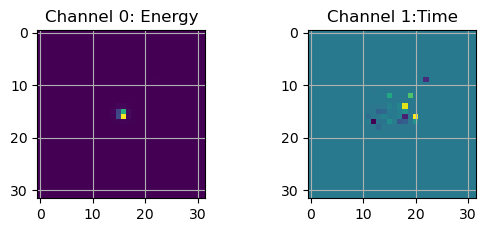

In [6]:
# A sample image from the dataset
plt.figure(1)

plt.subplot(221)
plt.imshow(X_train[1,:,:,0])
plt.title("Channel 0: Energy")
plt.grid(True)

plt.subplot(222)
plt.imshow(X_train[1,:,:,1])
plt.title("Channel 1:Time")
plt.grid(True)

plt.show

In [7]:
#Defining the model
model= models.Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(32,32,2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(units=64, activation='relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=1.e-3),
    metrics=['accuracy', tf.keras.metrics.AUC(curve='ROC')]
)

In [9]:
#Fitting the model
history= model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val),verbose=2)

Epoch 1/10
640/640 - 15s - 24ms/step - accuracy: 0.5718 - auc: 0.6079 - loss: 0.6726 - val_accuracy: 0.5918 - val_auc: 0.6289 - val_loss: 0.6661
Epoch 2/10
640/640 - 15s - 23ms/step - accuracy: 0.6147 - auc: 0.6556 - loss: 0.6522 - val_accuracy: 0.6146 - val_auc: 0.6450 - val_loss: 0.6567
Epoch 3/10
640/640 - 15s - 23ms/step - accuracy: 0.6365 - auc: 0.6775 - loss: 0.6397 - val_accuracy: 0.6234 - val_auc: 0.6641 - val_loss: 0.6510
Epoch 4/10
640/640 - 16s - 24ms/step - accuracy: 0.6554 - auc: 0.6988 - loss: 0.6256 - val_accuracy: 0.6361 - val_auc: 0.6760 - val_loss: 0.6398
Epoch 5/10
640/640 - 16s - 24ms/step - accuracy: 0.6751 - auc: 0.7231 - loss: 0.6100 - val_accuracy: 0.6434 - val_auc: 0.6923 - val_loss: 0.6310
Epoch 6/10
640/640 - 15s - 24ms/step - accuracy: 0.6862 - auc: 0.7398 - loss: 0.5979 - val_accuracy: 0.6549 - val_auc: 0.7047 - val_loss: 0.6285
Epoch 7/10
640/640 - 16s - 25ms/step - accuracy: 0.6971 - auc: 0.7558 - loss: 0.5853 - val_accuracy: 0.6504 - val_auc: 0.7033 - va

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


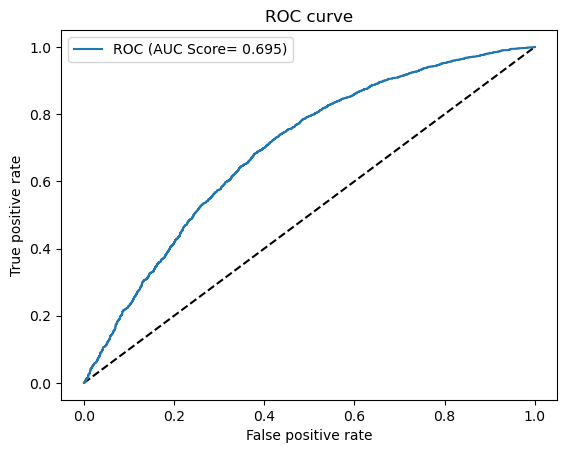

In [11]:
#Plotting the ROC Curve

from sklearn.metrics import roc_curve
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
from sklearn.metrics import auc
auc = auc(fpr, tpr)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC (AUC Score= {:.3f})'.format(auc))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [12]:
acc1= np.equal(y_test,np.round(y_pred)).mean()
print("Test accuracy:", acc1)

Test accuracy: 0.65234375


In [13]:
y_train_pred= model.predict(X_train).ravel()
acc= np.equal(y_train,np.round(y_train_pred)).mean()
print("Training accuracy:", acc)

640/640 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
Training accuracy: 0.75927734375
